# Testing Symmetry of Two Networks
The "symmetry" module of graspologic contains functions that enable quantitative comparison of two networks to assess whether they are statistically similar. This "similarity" can be assessed in a few different ways, depending on the details of the networks to be compared and the preferences of the user. 

The simplest test that can be performed is the Erdos-Renyi test, which is based upon the Erdos-Renyi model. Under this model, it is assumed that the probability of an edge between any two nodes of the network is some constant, p. To compare two networks, then, the question is whether the edge probability for the first network is different from the edge probability for the second network. This test can be performed easily with the symmetry module, and the procedure is described in greater detail below. 

The second test that can be performed with the symmetry module is the Group Connection Test, which is based upon the Stochastic Block Model. Under this model, each node in the network is treated as belonging to a single group or community, and the probability of an edge between any two nodes is assumed to be a function of the group or community to which each node belongs. Thus, rather than a single edge probability p for the probability of an edge between two nodes, there is a matrix of edge probabilities of size n x n, where n is the number of distinct groups in the network. Using the graspologic symmetry module, the user can compare two networks to assess both whether each individual group-to-group connection probability is different between the two networks, and can test whether the overall probability matrices are statistically different from one another. 

Below, the Erdos-Renyi test is demonstrated using data from the neural connectome of the _Drosophila Melanogaster_ fruit fly. In the next tutorial file, labeled "group_connection_test_tutorial," the Group Connection Test is demonstrated.

# Erdos-Renyi test
Here, we demonstrate the use of the Erdos-Renyi test to compare neural connections in the two hemispheres of the brain of the _Drosophila Melanogaster_. The purpose of this comparison is to assess whether the network densities differ between the two hemispheres of the brain.

## The Erdos-Renyi (ER) model
The [**Erdos-Renyi (ER) model**
](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
is one of the simplest network models. This model treats
the probability of each potential edge in the network occuring to be the same. In
other words, all edges between any two nodes are equally likely.

```{admonition} Math
Let $n$ be the number of nodes. We say that for all $(i, j), i \neq j$, with $i$ and
$j$ both running
from $1 ... n$, the probability of the edge $(i, j)$ occuring is:

$$ P[A_{ij} = 1] = p_{ij} = p $$

Where $p$ is the the global connection probability.

Each element of the adjacency matrix $A$ is then sampled independently according to a
[Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution):

$$ A_{ij} \sim Bernoulli(p) $$

For a network modeled as described above, we say it is distributed

$$ A \sim ER(n, p) $$

```

Thus, for this model, the only parameter of interest is the global connection
probability, $p$. This is sometimes also referred to as the **network density**.

## Testing under the ER model
In order to compare two networks $A^{(L)}$ and $A^{(R)}$ under this model, we
simply need to compute these network densities ($p^{(L)}$ and $p^{(R)}$), and then
run a statistical test to see if these densities are significantly different.

```{admonition} Math
Under this
model, the total number of edges $m$ comes from a $Binomial(n(n-1), p)$ distribution,
where $n$ is the number of nodes. This is because the number of edges is the sum of
independent Bernoulli trials with the same probability. If $m^{(L)}$ is the number of
edges on the left
hemisphere, and $m^{(R)}$ is the number of edges on the right, then we have:

$$m^{(L)} \sim Binomial(n^{(L)}(n^{(L)} - 1), p^{(L)})$$

and independently,

$$m^{(R)} \sim Binomial(n^{(R)}(n^{(R)} - 1), p^{(R)})$$

To compare the two networks, we are just interested in a comparison of $p^{(L)}$ vs.
$p^{(R)}$. Formally, we are testing:

$$H_0: p^{(L)} = p^{(R)}, \quad H_a: p^{(L)} \neq p^{(R)}$$

Fortunately, the problem of testing for equal proportions is well studied.
Using graspologic.symmetry, we can conduct this comparison using either
Fisher's exact test or the chi-squared test by using method="fisher" or 
method = "chi2", respectively. In this example, we use Fisher's exact test.
```

In [1]:
import datetime
import time

import matplotlib.path
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import merge_axes, soft_axis_off
from graspologic.simulations import er_np
from matplotlib.collections import LineCollection
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import SmartSVG, networkplot_simple, set_theme
from pkg.plot.er import plot_density
from pkg.stats import erdos_renyi_test
from pkg.utils import sample_toy_networks
from svgutils.compose import Figure, Panel, Text
from pkg.plot import draw_hypothesis_box, rainbowarrow


DISPLAY_FIGS = True

FILENAME = "er_unmatched_test"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme(font_scale=1.25)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

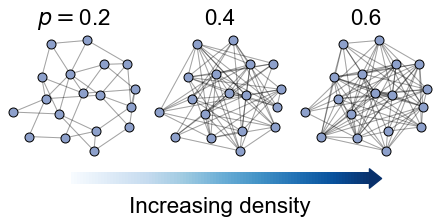

In [2]:
# describe ER model


np.random.seed(8888)
ps = [0.2, 0.4, 0.6]
n_steps = len(ps)
fig, axs = plt.subplots(
    2,
    n_steps,
    figsize=(6, 3),
    gridspec_kw=dict(height_ratios=[2, 0.5]),
    constrained_layout=True,
)
n = 18
for i, p in enumerate(ps):
    A = er_np(n, p)
    if i == 0:
        node_data = pd.DataFrame(index=np.arange(n))

    ax = axs[0, i]
    networkplot_simple(A, node_data, ax=ax, compute_layout=i == 0)

    label_text = f"{p}"
    if i == 0:
        label_text = r"$p = $" + label_text
    ax.set_title(label_text, pad=10)

fig.set_facecolor("w")


ax = merge_axes(fig, axs, rows=1)

soft_axis_off(ax)


rainbowarrow(ax, (0.15, 0.5), (0.85, 0.5), cmap="Blues", n=100, lw=12)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Increasing density")

gluefig("er_explain", fig)

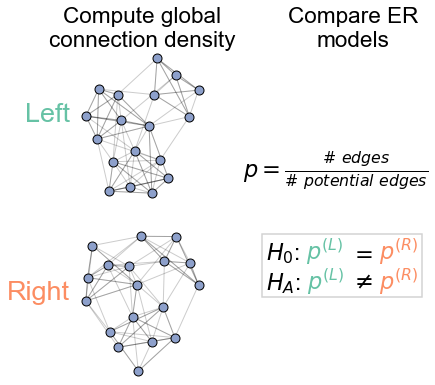

In [3]:
A1, A2, node_data = sample_toy_networks()
node_data["labels"] = np.ones(len(node_data), dtype=int)
palette = {1: sns.color_palette("Set2")[2]}
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=dict(wspace=0.7))

ax = axs[0, 0]
networkplot_simple(A1, node_data, ax=ax)

ax.set_title("Compute global\nconnection density")
ax.set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)


ax = axs[1, 0]
networkplot_simple(A2, node_data, ax=ax)

ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

stat, pvalue, misc = erdos_renyi_test(A1, A2)


ax = axs[0, 1]
ax.text(
    0.4,
    0.2,
    r"$p = \frac{\# \ edges}{\# \ potential \ edges}$",
    ha="center",
    va="center",
)
ax.axis("off")


ax.set_title("Compare ER\nmodels")
ax.set(xlim=(-0.5, 2), ylim=(0, 1))


ax = axs[1, 1]
ax.axis("off")

x = 0
y = 0.55


draw_hypothesis_box("er", -0.2, 0.8, ax=ax, fontsize="medium", yskip=0.2)


gluefig("er_methods", fig)

In [4]:
stat, pvalue, misc = erdos_renyi_test(left_adj, right_adj)
glue("pvalue", pvalue, form="pvalue")

In [5]:
n_possible_left = misc["possible1"]
n_possible_right = misc["possible2"]
glue("n_possible_left", n_possible_left)
glue("n_possible_right", n_possible_right)

density_left = misc["probability1"]
density_right = misc["probability2"]
glue("density_left", density_left, form="0.2g")
glue("density_right", density_right, form="0.2g")

n_edges_left = misc["observed1"]
n_edges_right = misc["observed2"]

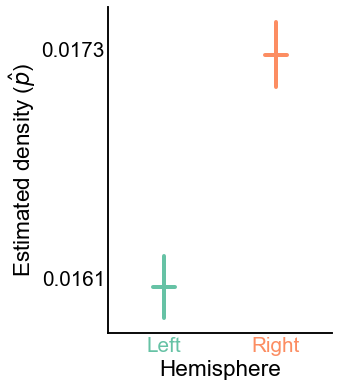

In [6]:

coverage = 0.95
glue("coverage", coverage, form="2.0f%")
plot_density(misc, palette=network_palette, coverage=coverage)

gluefig("er_density", fig)

## Reject bilateral symmetry under the ER model


```{glue:figure} fig:er_unmatched_test-er_density
:name: "fig:er_unmatched_test-er_density"

Comparison of estimated densities for the left and right hemisphere networks. The
estimated density (probability of any edge across the entire network), $\hat{p}$, for
the left
hemisphere is ~{glue:text}`er_unmatched_test-density_left:0.3f`, while for the right
it is
~{glue:text}`er_unmatched_test-density_right:0.3f`. Black lines denote
{glue:text}`er_unmatched_test-coverage_percentage`**%**
confidence intervals for this estimated parameter $\hat{p}$. The p-value for testing
the null hypothesis that these densities are the same is
{glue:text}`er_unmatched_test-pvalue:0.3g` (two
sided Fisher's exact test).
```


{numref}`Figure {number} <fig:er_unmatched_test-er_density>` shows the comparison of
the network densities between the left and right hemisphere induced subgraphs. We see
that the density on the left is ~{glue:text}`er_unmatched_test-density_left:0.3f`, and
on the right it is ~{glue:text}`er_unmatched_test-density_right:0.3f`. To determine
whether this is a difference likely to be observed by chance under the ER model,
we ran a two-sided Fisher's exact test, which tests whether the success probabilities
between two independent binomials are significantly different. This test yields a
p-value of {glue:text}`er_unmatched_test-pvalue:0.3g`, suggesting that we have strong
evidence to reject this version of our hypotheis of bilateral symmetry. We note that
while the difference between estimated densities is not massive, this low p-value
results from the large sample size for this comparison. We note that there are
{glue:text}`er_unmatched_test-n_possible_left:,.0f` and
{glue:text}`er_unmatched_test-n_possible_right:,.0f` potential edges on the left and
right,
respectively, making the sample size for this comparison quite large.

This example demonstrates the use of erdos_renyi_test to reject or fail to reject the null hypothesis that the network densities of two networks are equal. If the null hypothesis is rejected, then the two networks can be said to be statistically different, at least in terms of network density. 

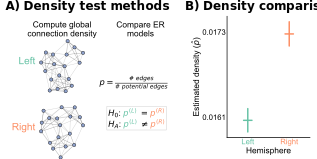

In [7]:

FIG_PATH = FIG_PATH / FILENAME

fontsize = 12

methods = SmartSVG(FIG_PATH / "er_methods.svg")
methods.set_width(200)
methods.move(10, 20)
methods_panel = Panel(
    methods, Text("A) Density test methods", 5, 10, size=fontsize, weight="bold")
)

density = SmartSVG(FIG_PATH / "er_density.svg")
density.set_height(methods.height)
density.move(10, 15)
density_panel = Panel(
    density, Text("B) Density comparison", 5, 10, size=fontsize, weight="bold")
)
density_panel.move(methods.width * 0.9, 0)

fig = Figure(
    (methods.width + density.width) * 0.9,
    (methods.height) * 0.9,
    methods_panel,
    density_panel,
)
fig.save(FIG_PATH / "composite.svg")
fig

In [8]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:05.504017
Completed at 2022-04-19 15:39:29.815304
